# Yelp Pulse

##### Generating Positive vs Negative Mentions from Yelp reviews for deeper sentiment understanding, leveraging LDA and BERT.

Hypothetical Requirement: [https://github.com/clement-hironimus/yelp-pulse-sentiment-analysis/blob/main/README.md](https://github.com/clement-hironimus/yelp-pulse-sentiment-analysis/blob/main/README.md)

&nbsp;
PROJECT OUTLINE:
- Step 1: Data Wrangling & Cleaning (see: 01_yelp_pulse_data_wrangling_and_cleaning.ipynb)
- Step 2: Exploratory Data Analysis (THIS NOTEBOOK)
- Step 3: Topic Extraction and Sentiment Classification (see: yelp_pulse_topic_extraction_and_sentiment_classification.ipynb)

## TLDR Summary: Key EDA Steps and Decisions

### Key Steps:
- **Exploratory Data Analysis (EDA)**: Investigated distributions, correlations, and categorical imbalances. Identified key numerical and categorical features impacting sentiment.
- **Feature Engineering**: Created `cleaned_review_text_length` and utilized existing business metrics like `business_average_review_stars` and `business_review_count`.
- **Correlation Analysis**: Utilized Spearman and Cramer's V metrics to identify relationships between features and sentiment.

### Key Findings:
- **Review Length**: Negative reviews tend to be lengthier, suggesting detailed expression of dissatisfaction.
- **Business Metrics**: Both the average review stars of a business and the number of reviews show potential predictive power for sentiment analysis.
- **Review Timing**: Variations in review sentiment observed based on time of day and week.

### Modeling Strategy:
- **Feature Utilization**: Including `business_average_review_stars`, `business_review_count`, and `cleaned_review_text_length` for modeling.
- **NLP Techniques**: Applying LDA & DistilBERT to extract sentiment-oriented features from `cleaned_review_text` for deep understanding and prediction of review sentiments.

### Next Steps:
- **Model Development**: Implement and train a neural network combining LDA, DistilBERT features, and selected business metrics.
- **Evaluation and Iteration**: Assess model performance and iteratively refine feature selection and model parameters to enhance predictive accuracy.

In [2]:
# Load Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
import calendar
from scipy import stats

# Visualize missing data
import matplotlib.pyplot as plt
import seaborn as sns

## Load Data

- Let's assume that "TODAY" is Jan 2022 as indicated from the latest Yelp review data.
- Containing reviews from 2017 - 2021.

Table column semantic & example:

```
{
    // string, the cleaned review text
    great burger fry salad burger hint salt pepper flavor location quaint outdoor seating friendly staff street parking well parking lot back

    // datetime (YYYY-MM-dd HH:mm:ss)
    "review_date": "2017-01-14 20:54:15",

    // integer, star rating
    "review_stars": 4,

    // integer, number of useful votes received
    "review_useful_count": 0,

    // integer, number of funny votes received
    "review_funny_count": 0,

    // integer, number of cool votes received
    "review_cool_count": 0

    // string, the business's name
    "business_name": "Garaje",

    // float, star rating, rounded to half-stars
    "business_average_review_stars": 4.5,

    // integer, number of reviews
    "business_review_count": 1198,

    // string, the full address of the business
    "business_address": "475 3rd St",

    // integer, 0 or 1 for closed or open, respectively
    "is_business_open": 1,

    // an array of strings of business categories
    "business_categories": [
        "Mexican",
        "Burgers",
        "Gastropubs"
    ]
    
    // string, the city
    "business_city": "San Francisco",

    // string, 2 character state code, if applicable
    "business_state": "CA",

    // string, the postal code
    "business_postal_code": "94107"

}
```

In [3]:
# Load Yelp Reviews
df_clean_yelp_review_and_business = pd.read_json(
    'clean_dataset/df_clean_yelp_review_and_business.json', 
    lines=True  # Using "lines" because each line in the file is a separate JSON object
)

# Converting from Unix timestamp format represented in milliseconds
df_clean_yelp_review_and_business['review_date'] = pd.to_datetime(df_clean_yelp_review_and_business['review_date'], unit='ms')

# Show data preview and the new rows & columns count after filtering
print(f'Rows & Cols Count: {df_clean_yelp_review_and_business.shape}')
df_clean_yelp_review_and_business.head()

Rows & Cols Count: (3797310, 16)


,cleaned_review_text,review_date,review_stars,review_useful_count,review_funny_count,review_cool_count,business_name,business_average_review_stars,business_review_count,business_address,is_business_open,business_categories,business_city,business_state,business_postal_code,business_country
0,decide eat aware going take hour beginning end...,2018-07-07 22:09:11,3,0.0,0.0,0.0,Turning Point of North Wales,3.0,169,1460 Bethlehem Pike,1,"Restaurants, Breakfast & Brunch, Food, Juice B...",North Wales,PA,19454,United States
1,cute interior owner gave u tour upcoming patio...,2017-01-14 20:54:15,4,1.0,0.0,1.0,Melt,4.0,32,2549 Banks St,0,"Sandwiches, Beer, Wine & Spirits, Bars, Food, ...",New Orleans,LA,70119,United States
2,really star one love th street naked tchopstix...,2018-07-17 03:30:07,4,1.0,0.0,1.0,Naked Tchopstix Express,3.5,33,"2902 W 86th St, Ste 70",0,"Restaurants, Food, Poke, Hawaiian, Sushi Bars",Indianapolis,IN,46268,United States
3,first time excellent feel like entering someon...,2017-02-19 13:32:05,5,0.0,0.0,0.0,Portobello Cafe,4.0,137,1423 Chester Pike,1,"Restaurants, Seafood, Cafes, Italian",Eddystone,PA,19022,United States
4,great burger fry salad burger hint salt pepper...,2017-01-02 03:17:34,5,0.0,0.0,0.0,The Original Habit Burger Grill,4.0,329,5735 Hollister Ave,1,"Fast Food, Burgers, Restaurants",Goleta,CA,93117,United States


In [4]:
# Quick data check in case there are obvious errors
df_clean_yelp_review_and_business.describe()

,review_date,review_stars,review_useful_count,review_funny_count,review_cool_count,business_average_review_stars,business_review_count,is_business_open
count,3797310,3.797310e+06,3.797307e+06,3.797308e+06,3.797309e+06,3.797310e+06,3.797310e+06,3.797310e+06
mean,2019-04-17 22:02:54.739929088,3.765176e+00,9.741662e-01,2.405986e-01,4.707684e-01,3.792690e+00,3.516589e+02,8.986614e-01
min,2017-01-01 00:00:35,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,5.000000e+00,0.000000e+00
25%,2018-02-26 04:37:26.750000128,3.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.500000e+00,4.100000e+01,1.000000e+00
50%,2019-03-12 22:53:12,5.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,4.000000e+00,1.280000e+02,1.000000e+00
75%,2020-05-21 19:34:18,5.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,4.500000e+00,3.430000e+02,1.000000e+00
max,2021-12-31 23:59:26,5.000000e+00,9.330000e+02,7.920000e+02,3.040000e+02,5.000000e+00,7.568000e+03,1.000000e+00
std,NaN,1.546696e+00,2.938160e+00,1.411967e+00,2.269119e+00,7.809093e-01,7.192271e+02,3.017766e-01


In [5]:
# Make sure data types are in the right format
integer_columns_to_convert = ['review_stars', 'review_useful_count', 'review_funny_count', 'review_cool_count', 'business_review_count']
for col in integer_columns_to_convert:
    df_clean_yelp_review_and_business[col] = df_clean_yelp_review_and_business[col].astype('Int64') # The capital "I" is to allow for NaNs in integer columns

# Confirm data type conversion
df_clean_yelp_review_and_business.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3797310 entries, 0 to 3797309
Data columns (total 16 columns):
 #   Column                         Dtype         
---  ------                         -----         
 0   cleaned_review_text            object        
 1   review_date                    datetime64[ns]
 2   review_stars                   Int64         
 3   review_useful_count            Int64         
 4   review_funny_count             Int64         
 5   review_cool_count              Int64         
 6   business_name                  object        
 7   business_average_review_stars  float64       
 8   business_review_count          Int64         
 9   business_address               object        
 10  is_business_open               int64         
 11  business_categories            object        
 12  business_city                  object        
 13  business_state                 object        
 14  business_postal_code           object        
 15  business_countr

In [6]:
# Convert BOOL type
df_clean_yelp_review_and_business['is_business_open'] = df_clean_yelp_review_and_business['is_business_open'].astype(bool)
df_clean_yelp_review_and_business['is_business_open'].value_counts()

is_business_open
True     3412496
False     384814
Name: count, dtype: int64

## Create Sentiment Labels

### Get Random Samples for Each Star

Looking at random samples for each `review_stars` (1 to 5), we can see that:
- Rating 1-2: Seems negative
- Rating 3: Mixed feelings/average experiences, neither clearly positive nor negative.
- Rating 4-5: Seems positive

In [7]:
# Get review random samples based on different stars
sampled_data = pd.DataFrame()

for i in range(1, 6):
    sampled_category = df_clean_yelp_review_and_business[df_clean_yelp_review_and_business['review_stars'] == i].sample(3, random_state=42)
    sampled_category['review_stars'] = i
    sampled_data = pd.concat([sampled_data, sampled_category], axis=0) # Append the new sample to "sampled_data" dataframe

sampled_data.reset_index(drop=True, inplace=True) # Reset index for more clarity
sampled_data[['review_stars', 'cleaned_review_text']]

,review_stars,cleaned_review_text
0,1,tried rent snow shoe called twice ask pricing ...
1,1,terrible customer service led write first revi...
2,1,u army veteran wendy advertised free breakfast...
3,2,place garbage feel fortunate giving star quite...
4,2,disappointing although many table empty pm res...
5,2,went evening friend birthday dinner sadly goin...
6,3,sunrise cafe located likely dying strip mall t...
7,3,food decent service good place kind ran super ...
8,3,first time strawberry festival thought pretty ...
9,4,husband love rudie great food awesome neighbor...


### Create the (Star-Based) Sentiment Label


Findings:
- **Class imbalance** between Positive vs Negative/Neutral reviews. Might suggest customers were generally satisfied or that users are more likely to post reviews when they have a positive experience.
- **Small Neutral reviews**, might suggest users were more definitive (positive or negative) about their experiences.

Potential treatments to consider on modeling phase:
- SMOTEN resampling to balance the sentiment classes, but not too much that it will just repeat/duplicate the records and still maintain the original balance of the data.
- Needing to use metrics like precision/recall/f-1 score/confusion matrix instead of accuracy to evaluate model performance due to class imbalance.
- If building a neural network, potentially penalize miss-classifications of minority classes more.

In [8]:
# Create the conditions
conditions = [
    df_clean_yelp_review_and_business['review_stars'] <= 2, # Negative
    df_clean_yelp_review_and_business['review_stars'] == 3, # Neutral
    df_clean_yelp_review_and_business['review_stars'] >= 4 # Positive
] 

choices = ['negative', 'neutral', 'positive'] # Corresponding to the above

df_clean_yelp_review_and_business['star_based_sentiment_label'] = np.select(conditions, choices, default=np.NaN)

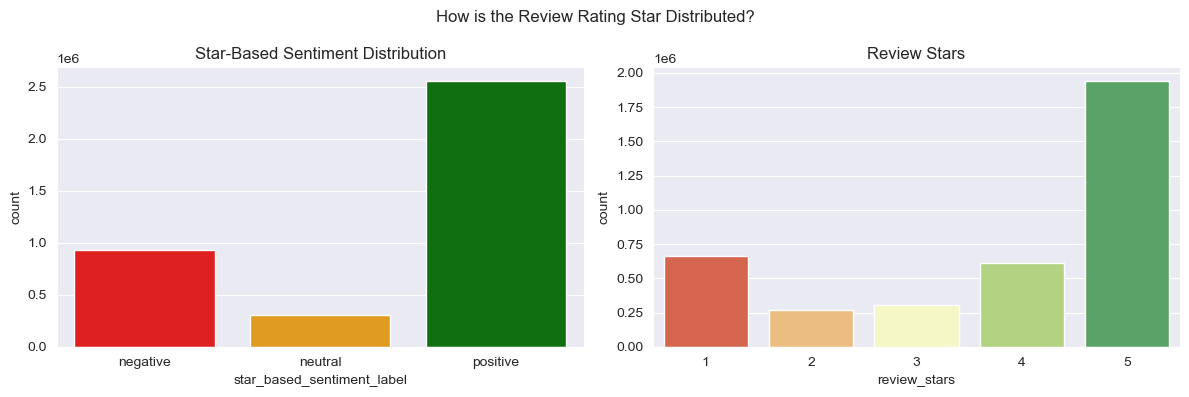

In [9]:
# Create subplots
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))

# Left plot for sentiment distribution
category_color = {'negative': 'red', 'neutral': 'orange', 'positive': 'green'}
sns.countplot(
    data=df_clean_yelp_review_and_business,
    x='star_based_sentiment_label', 
    order=['negative', 'neutral', 'positive'],
    palette=category_color,
    ax=ax1
)
ax1.set_title('Star-Based Sentiment Distribution')

# Right plot for review stars
sns.countplot(
    data=df_clean_yelp_review_and_business,
    x='review_stars',
    palette='RdYlGn',  # Using a built-in color palette for a red to green gradient
    ax=ax2
)
ax2.set_title('Review Stars')
plt.suptitle("How is the Review Rating Star Distributed?")
plt.tight_layout()
plt.show()  # Show the plots


## Create Review Length Variable
Do angry people tend to write a longer review than happy ones?

- From below boxplot visualization, users with Positive sentiment tends to write shorter reviews than users with Negative/Neutral sentiment.
- Will quantify the correlation later in this notebook.  

In [10]:
# Create the new column
df_clean_yelp_review_and_business['cleaned_review_text_length'] = df_clean_yelp_review_and_business['cleaned_review_text'].str.len()

# Preview data
df_clean_yelp_review_and_business[['cleaned_review_text', 'cleaned_review_text_length']].head()

,cleaned_review_text,cleaned_review_text_length
0,decide eat aware going take hour beginning end...,275
1,cute interior owner gave u tour upcoming patio...,376
2,really star one love th street naked tchopstix...,864
3,first time excellent feel like entering someon...,127
4,great burger fry salad burger hint salt pepper...,137


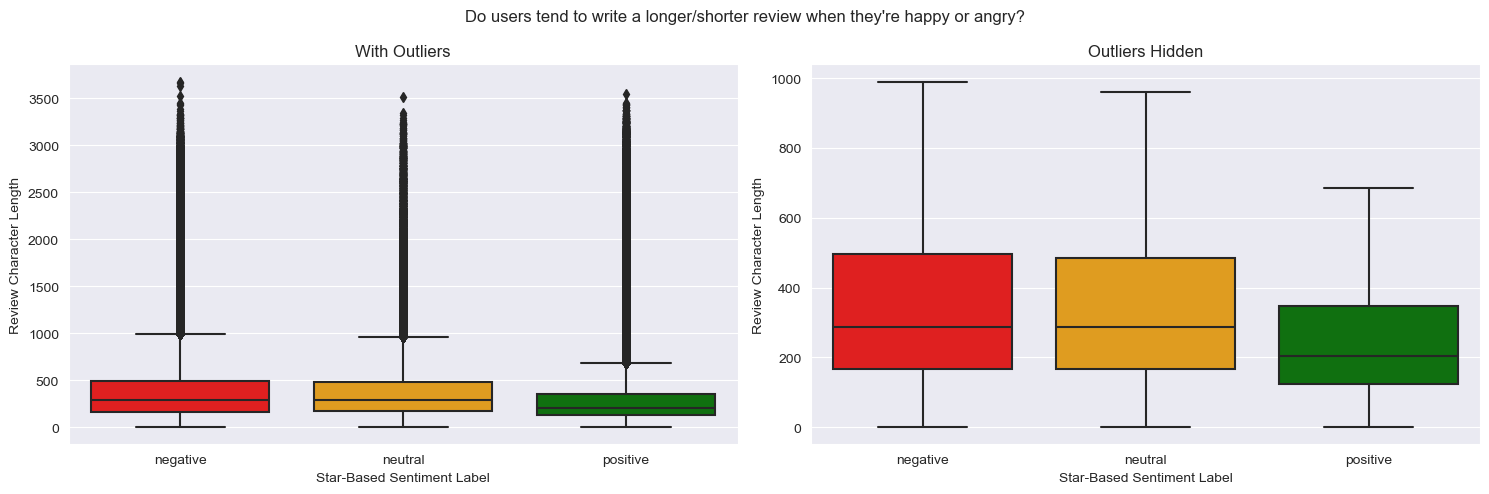

In [11]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

# Left Plot
sns.boxplot(
    data=df_clean_yelp_review_and_business,
    x='star_based_sentiment_label',
    y='cleaned_review_text_length',
    order=['negative', 'neutral', 'positive'],
    palette=category_color,
    ax=ax1
)
ax1.set_title("With Outliers")
ax1.set_xlabel('Star-Based Sentiment Label')
ax1.set_ylabel('Review Character Length')

# Right Plot (like above, but hiding outliers)
sns.boxplot(
    data=df_clean_yelp_review_and_business,
    x='star_based_sentiment_label',
    y='cleaned_review_text_length',
    order=['negative', 'neutral', 'positive'],
    palette=category_color,
    showfliers=False,
    ax=ax2
)
ax2.set_title('Outliers Hidden')
ax2.set_xlabel('Star-Based Sentiment Label')
ax2.set_ylabel('Review Character Length')

plt.suptitle("Do users tend to write a longer/shorter review when they're happy or angry?")
plt.tight_layout()
plt.show()

## Checking Numerical Data Distribution

### Count of Reviews Voted as Useful/Funny/Cool

Majority of reviews did not have any count (zero), while those with count are mostly below 200. We'll check later if these Cool/Funny/Useful counts might be useful in predicting Negative/Neutral/Positive sentiments.

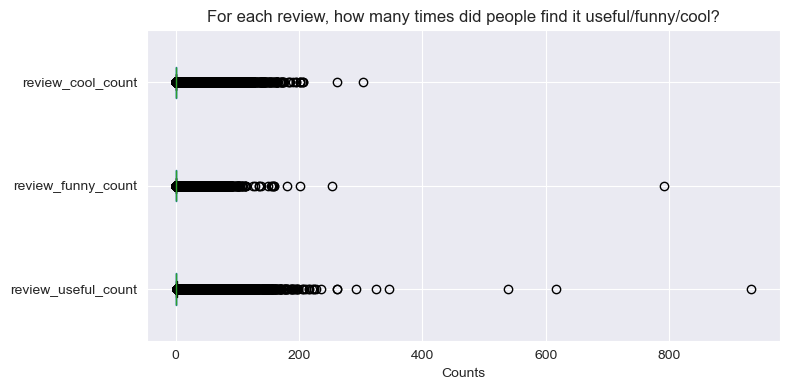

In [12]:
plt.figure(figsize=(8, 4)) # Increase the figure size

ax = df_clean_yelp_review_and_business[['review_useful_count', 'review_funny_count', 'review_cool_count']].boxplot(
    vert=False  # Orient the boxes horizontally
)

ax.set_title('For each review, how many times did people find it useful/funny/cool?')
ax.set_xlabel('Counts')
plt.tight_layout()
plt.show()

### Do businesses with Negative/Neutral/Positive sentiments tend to have lower/higher ratings?

Might rather be obvious, that:
- Positive sentiment is attributed to businesses with higher average ratings (4 to 4.5).
- Negative sentiment is attributed to businesses with lower average ratings (2.5 to 4).
- Neutral sentiment is attributed to businesses with middle average ratings (3.5 to 4).

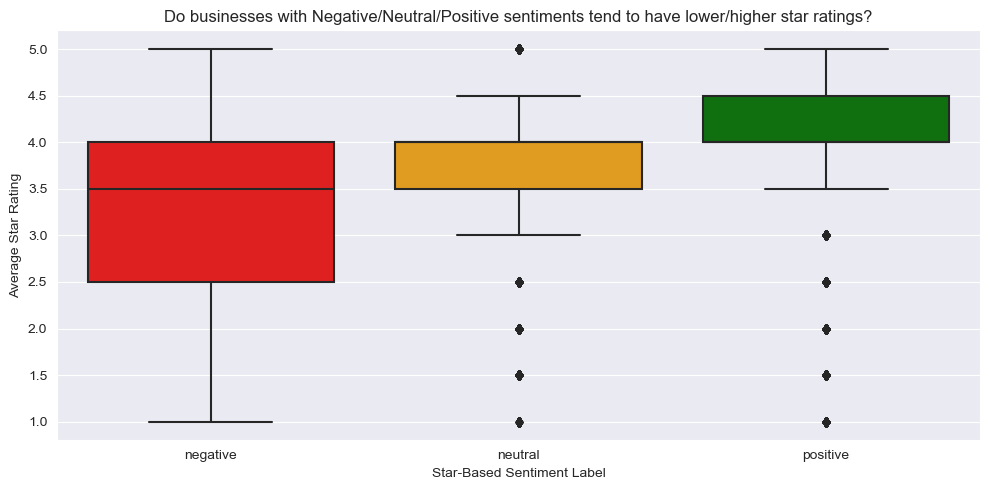

In [13]:
# Average review stars for businesses
plt.figure(figsize=(10, 5))  # Increase the figure size

ax = sns.boxplot(
    data=df_clean_yelp_review_and_business,
    x='star_based_sentiment_label',
    y='business_average_review_stars',
    order=['negative', 'neutral', 'positive'],
    palette=category_color
)

ax.set_title("Do businesses with Negative/Neutral/Positive sentiments tend to have lower/higher star ratings?")
ax.set_xlabel('Star-Based Sentiment Label')
ax.set_ylabel('Average Star Rating')
plt.tight_layout()
plt.show()

### How many reviews does a business typically have?

Mostly between 1 - 49 reviews. 

In [14]:
# Selecting distinct businesses based on the specified subset to prevent over-counting since 1 business can have >1 reviews
business_dupe_subset = ['business_name', 'business_address', 'is_business_open']
df_business_deduped = df_clean_yelp_review_and_business.drop_duplicates(subset=business_dupe_subset)

/var/folders/f0/p4s7pwrs3sv6n38m4jy52yg00000gp/T/ipykernel_25650/2068651272.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_business_deduped.loc[:, 'business_review_count_category'] = np.select(condition_list, choice_list, default='Invalid (Negative)')


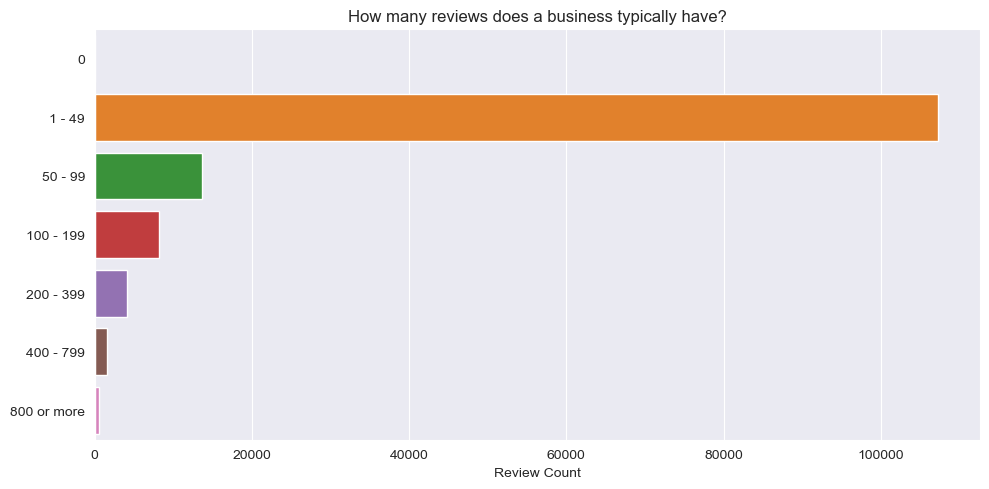

In [15]:
# Categories
condition_list = [
    df_business_deduped['business_review_count'] == 0,
    (df_business_deduped['business_review_count'] >= 1) & (df_business_deduped['business_review_count'] <= 49),
    (df_business_deduped['business_review_count'] >= 50) & (df_business_deduped['business_review_count'] <= 99),
    (df_business_deduped['business_review_count'] >= 100) & (df_business_deduped['business_review_count'] <= 199),
    (df_business_deduped['business_review_count'] >= 200) & (df_business_deduped['business_review_count'] <= 399),
    (df_business_deduped['business_review_count'] >= 400) & (df_business_deduped['business_review_count'] <= 799),
    df_business_deduped['business_review_count'] >= 800
]

choice_list = [
    '0',
    '1 - 49',
    '50 - 99',
    '100 - 199',
    '200 - 399',
    '400 - 799',
    '800 or more'
]

# Use .loc to explicitly modify the DataFrame and avoid SettingWithCopyWarning
df_business_deduped.loc[:, 'business_review_count_category'] = np.select(condition_list, choice_list, default='Invalid (Negative)')

# Plotting the data
plt.figure(figsize=(10, 5))  # Increase the figure size

ax = sns.countplot(
    data=df_business_deduped, 
    y='business_review_count_category',
    order=choice_list
)
ax.set_title("How many reviews does a business typically have?")
ax.set_xlabel('Review Count')
ax.set_ylabel('')
plt.tight_layout()
plt.show()

## Checking Categorical Data Distribution

### Top Business Country

Most businesses are from United States (96%) and Canada (3.5%).

Side Note: The country is generated in previous notebook (`01_yelp_pulse_data_preprocessing.ipynb`) utilizing `geopy.geocoders.Nominatim` library. There are few "Not Found" Country because there were typos in the "Business City" in original dataset. They were not removed because they still contained valid review data in which we're primarily interested in.

There are few "Not Found" countries where there was a typo in the "City" which resulted  

In [16]:
# Checking the most common Business Country
pd.DataFrame({
    'Country Count': df_business_deduped['business_country'].value_counts(),
    'Percentage': df_business_deduped['business_country'].value_counts(normalize=True),
}).reset_index()

,business_country,Country Count,Percentage
0,United States,130223,0.962718
1,Canada,4797,0.035463
2,France,132,0.000976
3,Not Found,99,0.000732
4,Panamá,3,0.000022
5,Polska,2,0.000015
6,Argentina,1,0.000007
7,Việt Nam,1,0.000007
8,Venezuela,1,0.000007
9,Ecuador,1,0.000007


### Top Business Categories & States
- There are 1,300 categories, top-3 are Restaurant, Food, & Shopping representing 15% of all businesses, while top-35 represent 50% of all businesses.
- There are 26 states in the dataset, half of businesses are located in Pennsylvania, Florida, and Tennessee, while top-10 states represent 90% of all businesses.

In [17]:
# Create the count of each category and store the result in dataframe
categories_count = defaultdict(int)

for categories in df_business_deduped['business_categories'].fillna('N/A'):
    for category in categories.split(', '):
        categories_count[category] += 1
        
df_business_categories_count = pd.DataFrame(categories_count.items(), columns=['category', 'count']).sort_values(by='count', ascending=False).reset_index()
df_business_categories_count['count_cumsum_pct'] = df_business_categories_count['count'].cumsum() / df_business_categories_count['count'].sum()

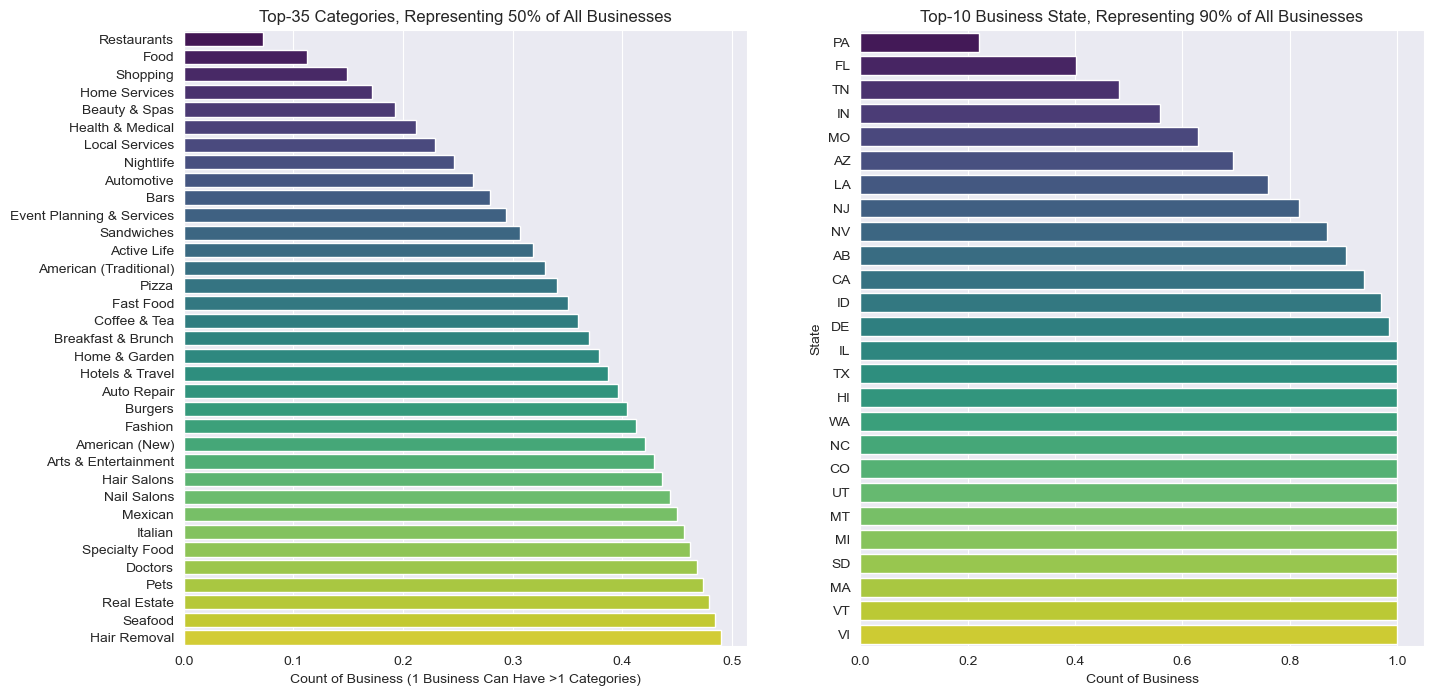

In [18]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(16, 8))

# Left Plot for Top-35 Categories (representing 50% of all 1,300 categories)
sns.barplot(
    data=df_business_categories_count[:35],
    y='category',
    x='count_cumsum_pct',
    palette='viridis',
    ax=ax1
)

# Add title and labels
ax1.set_title('Top-35 Categories, Representing 50% of All Businesses')
ax1.set_xlabel('Count of Business (1 Business Can Have >1 Categories)')
ax1.set_ylabel('')


# Right Plot for Count of Businesses by State
sns.barplot(
    data=df_business_deduped['business_state'].value_counts(normalize=True).cumsum().reset_index(), # Get cumulative percentage count of businesses on each state
    y='business_state',
    x='proportion',
    # order=df_business_deduped['business_state'].value_counts().index,
    palette='viridis',
    ax=ax2
)

# Add title and labels
ax2.set_title('Top-10 Business State, Representing 90% of All Businesses')
ax2.set_xlabel('Count of Business')
ax2.set_ylabel('State')

plt.show()

## Exploring Date-Based Data

- Explore trends over time, such as review counts or average review stars over different months or years. This could help identify any temporal patterns affecting reviews.
- Consider date-based distributions using review_date to understand temporal patterns in reviews.

### Quarterly Review Star

The review star ratings seemed to show a relatively steady mean of ~3.7 out of 5 in the past 4 years, while median has increased from 4.0 (2017) to 5.0 (from 2018-Q1 onwards). 

In [19]:
# Create a new column for Review Year-Quarter
df_clean_yelp_review_and_business['review_year_quarter'] = df_clean_yelp_review_and_business['review_date'].dt.to_period('Q')

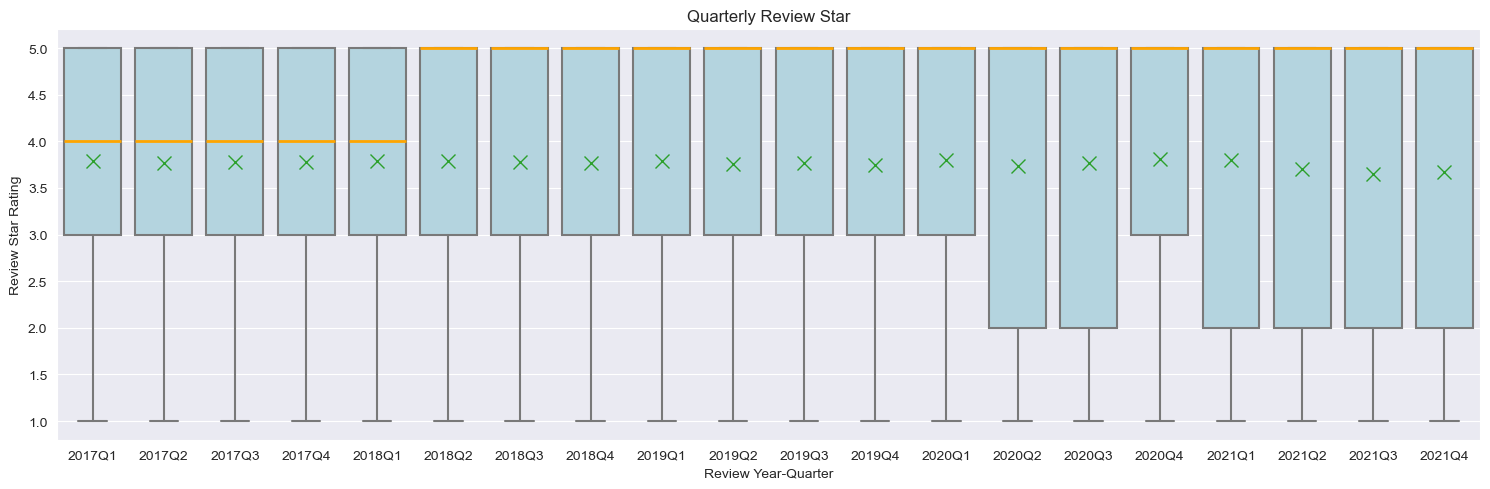

In [20]:
# Review Stars Trends by Year-Quarter
plt.figure(figsize=(15, 5))
ax = sns.boxplot(
    data=df_clean_yelp_review_and_business.sort_values(by='review_year_quarter'),
    x='review_year_quarter',
    y='review_stars',
    color='lightblue',
    medianprops={'color': 'orange', 'linewidth': 2}, # Format median line
    showmeans=True, # Show mean symbol
    meanprops={'color': 'red', 'marker': 'x', 'markersize': 10}
)

# Adding title and labels
plt.title('Quarterly Review Star')
plt.xlabel('Review Year-Quarter')
plt.ylabel('Review Star Rating')

plt.tight_layout()
plt.show()

### Review Star by Day-Of-Week

Something quite interesting that Review Stars median is lower on Monday & Sunday (4.0 out of 5) and higher on Tuesday - Saturday (5.0 out of 5). 

In [21]:
df_clean_yelp_review_and_business['review_day_of_week'] = df_clean_yelp_review_and_business['review_date'].dt.day_name()

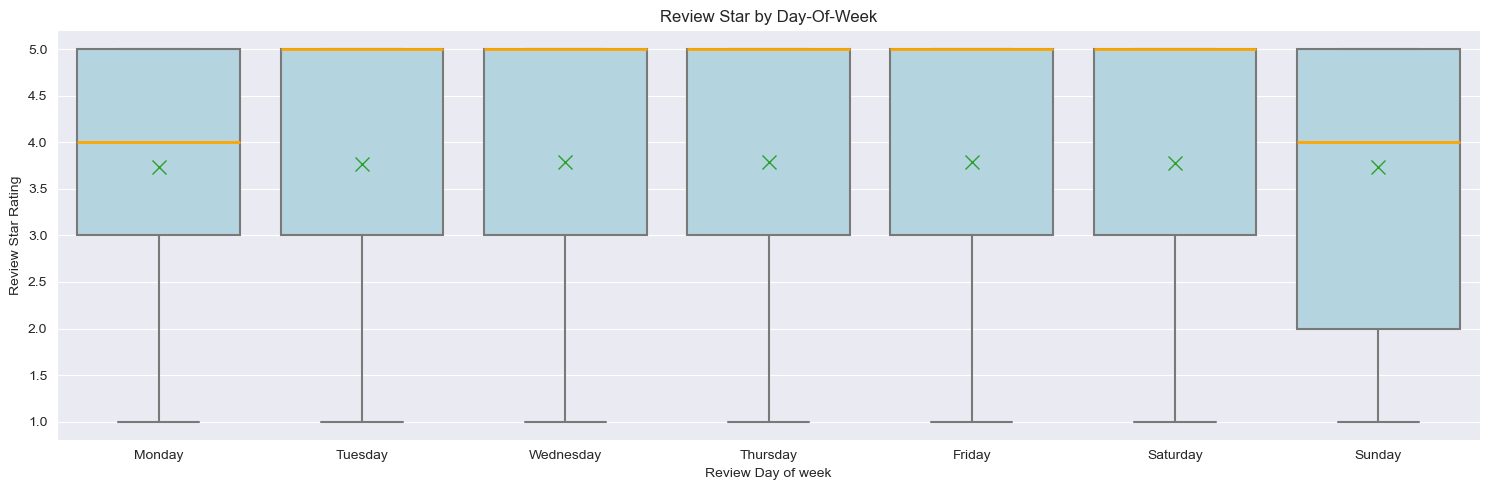

In [22]:
# Review Stars Trends by Day of the Week
plt.figure(figsize=(15, 5))
ax = sns.boxplot(
    data=df_clean_yelp_review_and_business,
    x='review_day_of_week',
    y='review_stars',
    color='lightblue',
    medianprops={'color': 'orange', 'linewidth': 2}, # Format median line
    showmeans=True, # Show mean symbol
    meanprops={'color': 'red', 'marker': 'x', 'markersize': 10},
    order=list(calendar.day_name)
)

# Adding title and labels
plt.title('Review Star by Day-Of-Week')
plt.xlabel('Review Day of week')
plt.ylabel('Review Star Rating')

plt.tight_layout()
plt.show()

### Review Star by Hour-of-Day

Another interesting insights where review star rating tend to be lower between 3AM - 12PM, shown by median of 4.0 out of 5. 

In [23]:
df_clean_yelp_review_and_business['review_hour'] = df_clean_yelp_review_and_business['review_date'].dt.hour

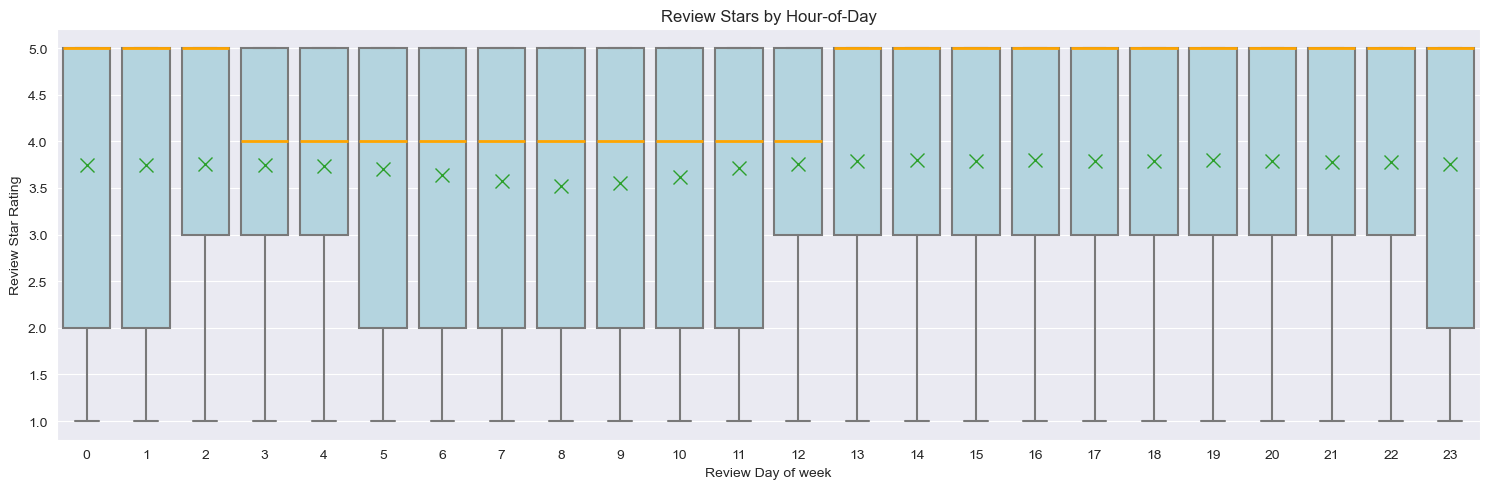

In [24]:
# Review Stars Trends by Day of the Week
plt.figure(figsize=(15, 5))
ax = sns.boxplot(
    data=df_clean_yelp_review_and_business,
    x='review_hour',
    y='review_stars',
    color='lightblue',
    medianprops={'color': 'orange', 'linewidth': 2}, # Format median line
    showmeans=True, # Show mean symbol
    meanprops={'color': 'red', 'marker': 'x', 'markersize': 10},
    order=range(24)
)

# Adding title and labels
plt.title('Review Stars by Hour-of-Day')
plt.xlabel('Review Day of week')
plt.ylabel('Review Star Rating')

plt.tight_layout()
plt.show()

## Outliers Observation and Preprocessing Plan
- Most count-related features display significant right skewness which might require Log Transformation & RobustScaler.
    - Examples: `review_useful_count`, `review_funny_count`, `review_cool_count`, `business_average_review_stars`, `business_review_count`, `cleaned_review_text_length` 
- `review_hour` showed Bimodal Distribution & might need cyclical encoding for models considering time patterns.

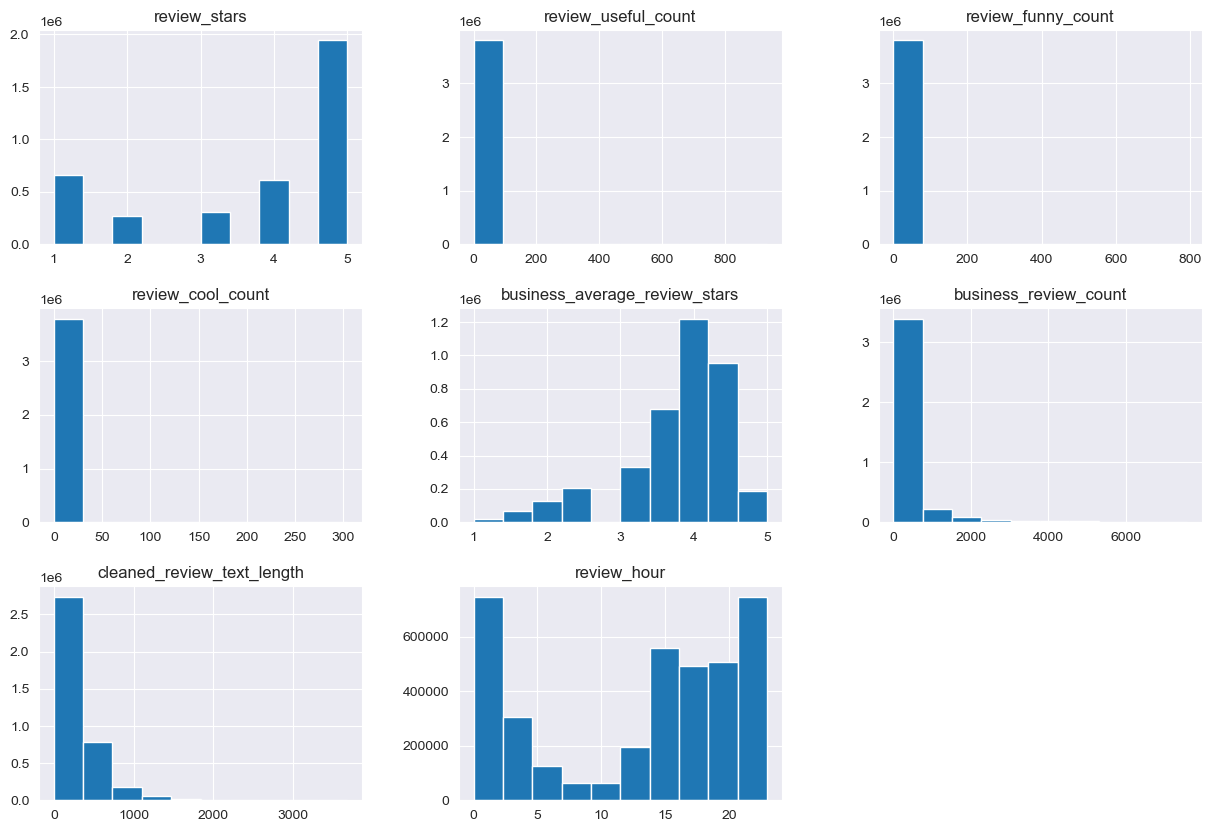

In [25]:
_ = df_clean_yelp_review_and_business.select_dtypes(include=['int', 'float']).hist(figsize=(15, 10))

## Spearman Correlation Analysis

Checking correlation with the Target Variable (`star_based_sentiment_numeric`)
&nbsp;
<img src="images/spearman_matrix.png" alt="Spearman Correlation Matrix" title="Spearman Correlation Matrix" width="2400"/>

- Moderate Correlation:
    - **`business_average_review_stars`**: Moderate positive correlation of 45%, suggesting it reflects general sentiment towards the business.
- Weak Correlation:
    - **`review_useful_count`**, **`review_funny_count`**, and **`review_cool_count`**: Correlation of -9%, -8%, and 18% respectively.
        - Interesting that users seemed to find Positive reviews as "Cool" while Negative reviews as "Useful" or "Funny".
    - **`cleaned_review_text_length`**: Negative Correlation of 18%, suggesting users seemed to write more for Negative reviews.
    - **`business_review_count`**: Positive Correlation of 12%, might suggest businesses with more reviews/more experience seemed to have more positive sentiment.

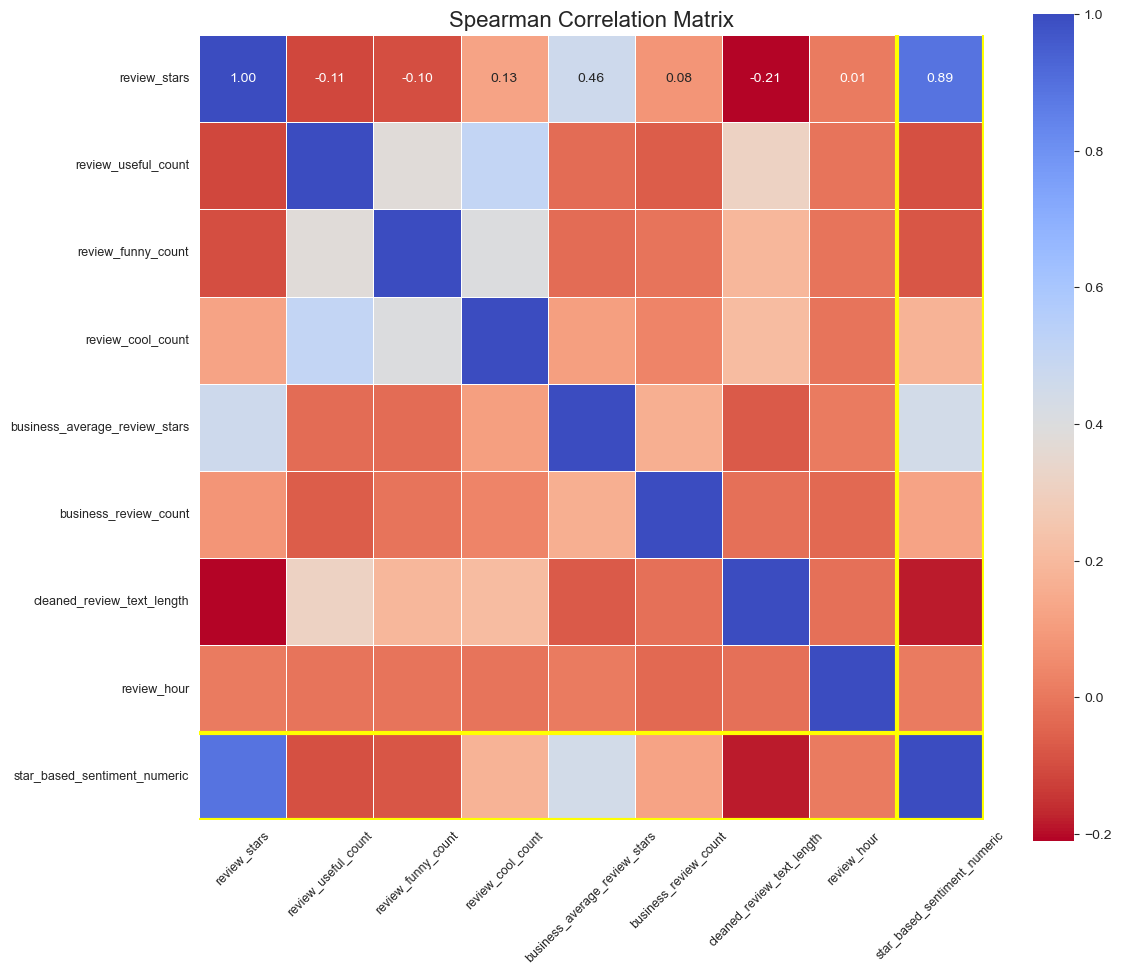

In [26]:
# Mapping categorical to numerical for correlation analysis
sentiment_mapping = {'negative': 1, 'neutral': 2, 'positive': 3}
df_clean_yelp_review_and_business['star_based_sentiment_numeric'] = df_clean_yelp_review_and_business['star_based_sentiment_label'].map(sentiment_mapping)

# Select numerical columns and add the newly created 'star_based_sentiment_numeric'
numerical_columns = list(df_clean_yelp_review_and_business.select_dtypes(include=['int', 'float']).columns)

# Compute the Spearman correlation matrix including 'star_based_sentiment_numeric'
spearman_correlation_matrix = df_clean_yelp_review_and_business[numerical_columns].corr(method='spearman')

# Plotting the heatmap
plt.figure(figsize=(12, 10))
cmap = sns.color_palette("coolwarm_r", as_cmap=True)
sns.heatmap(
    spearman_correlation_matrix, 
    annot=True, 
    fmt='.2f',
    cmap=cmap,
    square=True,
    linewidths=.5
)

# Highlighting 'star_based_sentiment_numeric' column and row
field_index = spearman_correlation_matrix.columns.get_loc('star_based_sentiment_numeric')
plt.axhline(y=field_index, color='yellow', linewidth=3)
plt.axhline(y=field_index+1, color='yellow', linewidth=3)
plt.axvline(x=field_index, color='yellow', linewidth=3)
plt.axvline(x=field_index+1, color='yellow', linewidth=3)

# Title and labels
plt.title("Spearman Correlation Matrix", fontsize=16)
plt.xticks(rotation=45, fontsize=9)
plt.yticks(fontsize=9)
plt.tight_layout()
plt.show()


## Categorical Association Test with Cramer's V
Cramer's V quantifies the strength of association between two categorical variables, ranging from 0 (no association) to 1 (perfect association). It derives from the Pearson Chi-square statistic from a contingency table. Unlike the Chi-square test, which only confirms the presence of an association through a p-value, Cramer's V provides a value that interprets the strength of this association. This makes it a more comprehensive tool for understanding how strongly the variables are related.

&nbsp;
#### Formula:
$$V = \sqrt{\frac{\chi^2 / n}{\min(c-1, r-1)}}$$

- $\chi^2$ is the Chi-square statistic from the contingency table.
- $n$ is the total number of observations.
- $c$ and $r$ are the number of columns and rows in the contingency table, respectively.

Checking correlation with the Target Variable (`star_based_sentiment_label`)
&nbsp;
<img src="images/cramer_v_matrix.png" alt="Cramer's V Association Matrix" title="Cramer's V Association Matrix" width="2400"/>
- **Business City**: Moderate association with "star_based_sentiment_label" (Cramer's V = 0.0947), potentially useful for predicting categorical sentiment based on regional differences.
- **Business State**: Lower association with "star_based_sentiment_label" (Cramer's V = 0.0504), indicating weaker predictiveness.
- **Other Variables**: Show generally low Cramer's V values, suggesting minimal categorical association with sentiment labels.

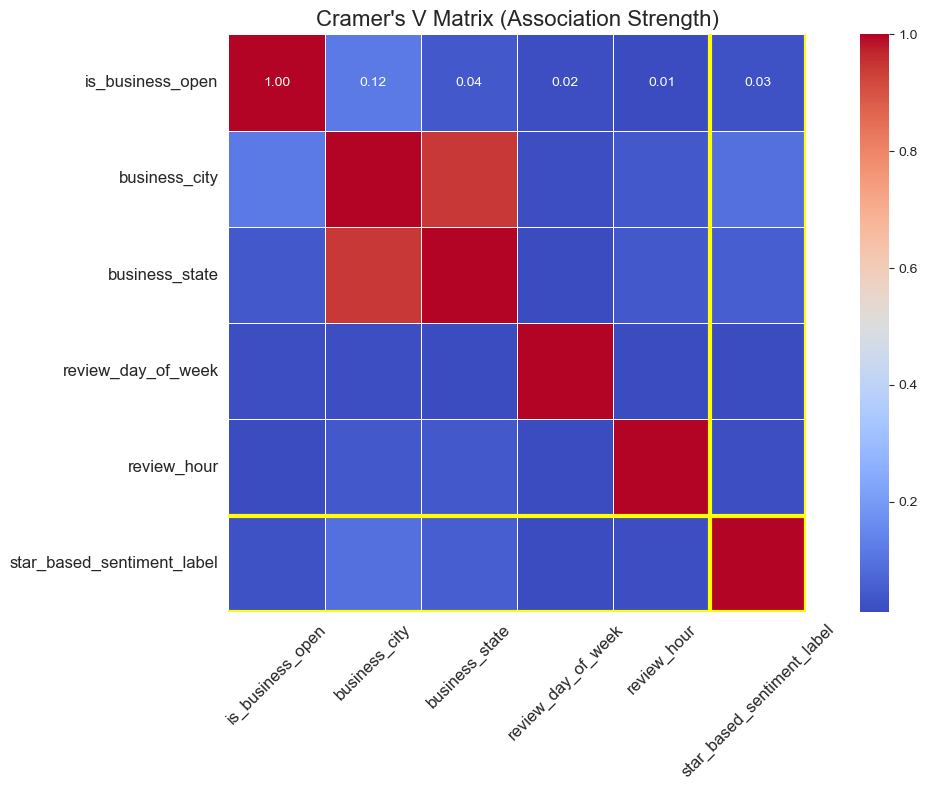

In [27]:
# Categorical columns to analyze
categorical_columns = ['is_business_open', 'business_city', 'business_state', 'review_day_of_week', 'review_hour', 'star_based_sentiment_label']

# Define empty DataFrames to store Cramer's V values
cramerv_matrix = pd.DataFrame(index=categorical_columns, columns=categorical_columns)

# Loop over each pair of categories
for row in categorical_columns:
    for col in categorical_columns:
        # Create contingency table
        contingency_table = pd.crosstab(df_clean_yelp_review_and_business[row], df_clean_yelp_review_and_business[col])
        
        # Perform chi-square test
        chi2, p_value, _, _ = stats.chi2_contingency(contingency_table)
        
        # Compute Cramer's V
        n = contingency_table.sum().sum()
        phi2 = chi2 / n
        r, k = contingency_table.shape
        phi2_corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))    
        r_corr = r - ((r-1)**2)/(n-1)
        k_corr = k - ((k-1)**2)/(n-1)
        cramerv_value = np.sqrt(phi2_corr / min(k_corr-1, r_corr-1))
        
        # Store the computed Cramer's V value in its respective matrix
        cramerv_matrix.loc[row, col] = cramerv_value

# Convert the Matrix DataFrame values to float
cramerv_matrix = cramerv_matrix.astype(float)

# Create a heatmap plot
plt.figure(figsize=(12, 8))
cmap = sns.color_palette("coolwarm", as_cmap=True)
sns.heatmap(
    cramerv_matrix, 
    annot=True, 
    fmt='.2f',
    cmap=cmap,
    square=True,
    linewidths=.5
)

# Highlighting 'star_based_sentiment_numeric' column and row
field_index = cramerv_matrix.columns.get_loc('star_based_sentiment_label')
plt.axhline(y=field_index, color='yellow', linewidth=3)
plt.axhline(y=field_index+1, color='yellow', linewidth=3)
plt.axvline(x=field_index, color='yellow', linewidth=3)
plt.axvline(x=field_index+1, color='yellow', linewidth=3)

# Set the title and display the plot
plt.title("Cramer's V Matrix (Association Strength)", fontsize=16)
plt.xticks(rotation=45, fontsize=12)  # Rotate x labels
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()


## Save Dataset

In [36]:
df_yelp_review_and_business_features_and_business_metadata = df_clean_yelp_review_and_business[[
    'cleaned_review_text',
    'business_average_review_stars',
    'business_review_count',
    'cleaned_review_text_length',
    'review_stars',
    'star_based_sentiment_label',
    
    # Not features, but used later when developing the interface
    'business_name',
    'business_categories',
    'business_city',
    'business_state',
    'business_country'
]]

In [37]:
# Check column types
df_yelp_review_and_business_features_and_business_metadata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3797310 entries, 0 to 3797309
Data columns (total 11 columns):
 #   Column                         Dtype  
---  ------                         -----  
 0   cleaned_review_text            object 
 1   business_average_review_stars  float64
 2   business_review_count          Int64  
 3   cleaned_review_text_length     int64  
 4   review_stars                   Int64  
 5   star_based_sentiment_label     object 
 6   business_name                  object 
 7   business_categories            object 
 8   business_city                  object 
 9   business_state                 object 
 10  business_country               object 
dtypes: Int64(2), float64(1), int64(1), object(7)
memory usage: 325.9+ MB


In [38]:
# Save the DataFrame to a JSON file
df_yelp_review_and_business_features_and_business_metadata.to_json(
    'clean_dataset/yelp_review_and_business_features_and_business_metadata.json', 
    orient='records', # Each row as a JSON object, suited for item-based manipulation and API usage.
    lines=True, # Each object on a new line, ideal for streaming and incremental processing.
    index=False # Exclude index to prevent data redundancy, as unique identifiers are present.
)